In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import os
sns.set(style="darkgrid")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 800)
pd.options.display.float_format = '{:.4f}'.format

from sklearn.metrics import mean_squared_error

In [2]:
#https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set
df = pd.read_csv('data/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
for col in df.columns.tolist():
    df[col] = df[col].fillna(df[col].mean())
    
daily = df.resample('D').sum()
ts = daily['Global_active_power']

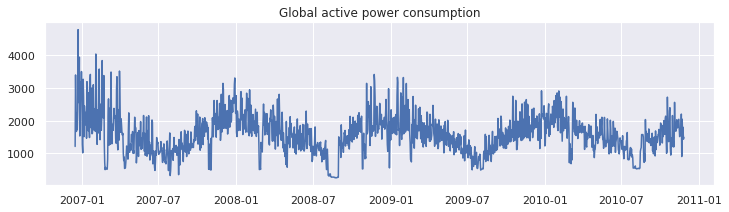

In [3]:
plt.figure(figsize=(12,3))
plt.plot(ts)
plt.title('Global active power consumption')
plt.show()

### Generate missing data

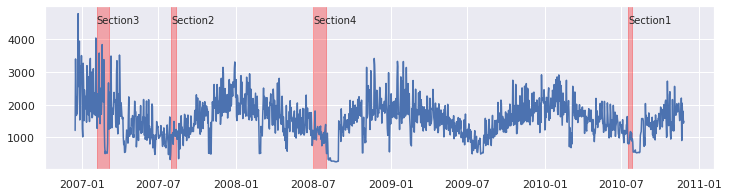

In [4]:
random.seed(42)
ts_missing = []
ts_missing_len = [10,10,30,30]
for i in range(len(ts_missing_len)):
    start = random.randint(0, len(ts))
    ts_missing.append((start,start+ts_missing_len[i]))

plt.figure(figsize=(12,3))
plt.plot(ts)
for i,section in enumerate(ts_missing):
    plt.axvspan(ts.index[section[0]],ts.index[section[1]],color='red', alpha=0.3)
    plt.text(ts.index[section[0]],4500,f'Section{i+1}')
plt.show()    

In [5]:
train = pd.DataFrame(ts)
train.columns = ['y_true']
train['y'] = train['y_true']
for section in ts_missing:
    train.iloc[range(section[0],section[1]),1]=np.nan    
train.shape

(1442, 2)

In [10]:
def plot_imputaion(show_ci = True, title=''):    
    plt.subplots(len(ts_missing),1,figsize=(12,len(ts_missing)*2))
    plt.suptitle(title)
    for i,section in enumerate(ts_missing):    
        plt.subplot(len(ts_missing),1,i+1)
        plot_df = train.iloc[range(section[0]-30,section[1]+30),:]
        plt.plot(plot_df['y_mean'], label='imputed')
        plt.plot(plot_df['y_true'], label='true')
        if show_ci:
            plt.fill_between(plot_df.index,plot_df['y_mean'] + 3*plot_df['y_std'], 
                             plot_df['y_mean'] - 3*plot_df['y_std'], alpha=0.3,
                            label='99% confidence interval')        
        plt.title(f"Section {i+1} RMSE:{round(mean_squared_error(plot_df['y_mean'],plot_df['y_true'],squared=False),2)}")
        plt.axvspan(ts.index[section[0]],ts.index[section[1]],color='red', alpha=0.1)    
        plt.legend(loc='lower left')          
    plt.tight_layout()    
    plt.show()

### Imputation with a single value (forward filling)

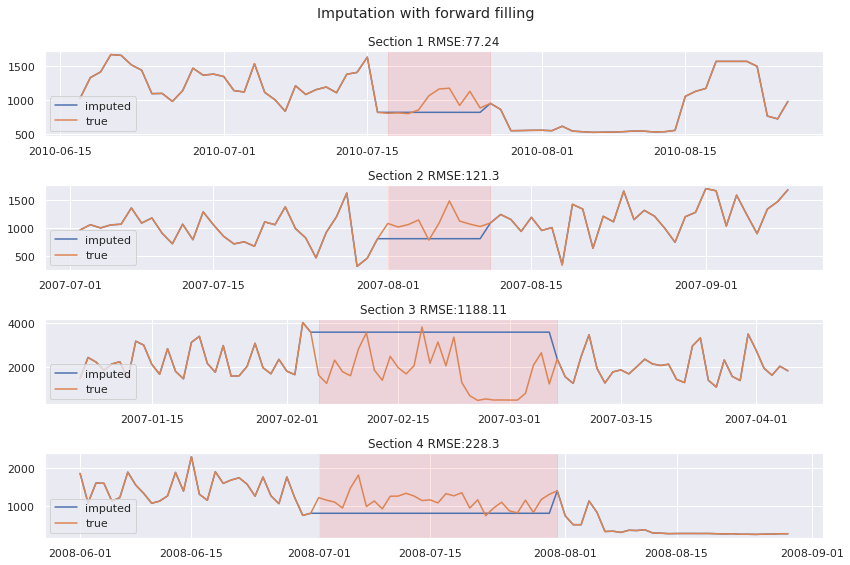

In [11]:
train['y_mean'] = train['y'].fillna(method='ffill')
train['y_std'] = 0

plot_imputaion(show_ci=False, title='Imputation with forward filling')

### Imputation by interpolation

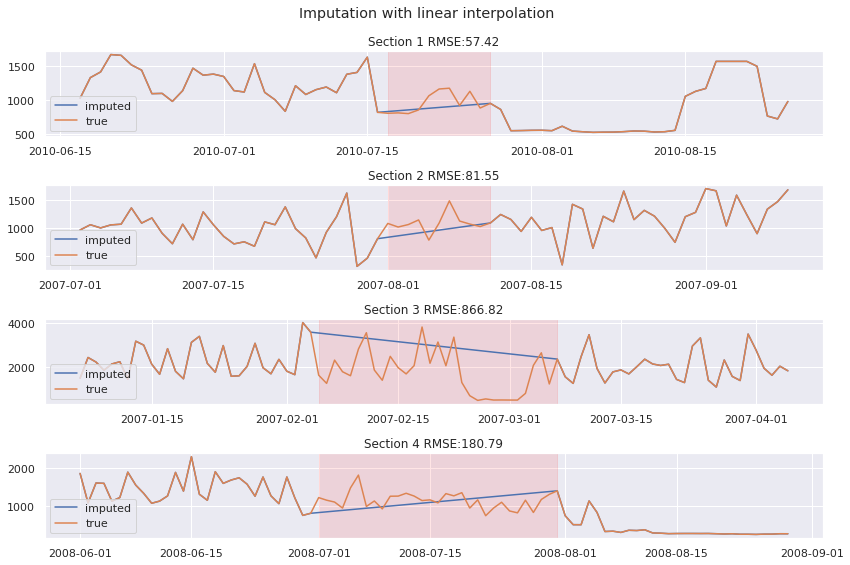

In [12]:
train['y_mean'] = train['y'].interpolate(method='linear')
train['y_std'] = 0

plot_imputaion(show_ci=False, title='Imputation with linear interpolation')

### Imputation with Multiple Imputation (sklearn IterativeImputer)

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from numpy.lib.stride_tricks import sliding_window_view

In [14]:
%%time

win_size = 90
X = sliding_window_view(train['y'].values,win_size)

#add the month info
X = np.concatenate((X, train.index.month.values[:len(X)].reshape(-1,1)), axis=1)

imp = IterativeImputer(random_state=0)
X_imp = imp.fit_transform(X)

CPU times: user 2min 23s, sys: 3min 27s, total: 5min 50s
Wall time: 17.6 s


/home/ning/python3.7-virtualenv/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [15]:
matrix = X_imp[:,range(win_size)]
diags = [matrix[::-1,:].diagonal(i) for i in range(-matrix.shape[0]+1,matrix.shape[1])]

train['y_mean'] = np.nan
train['y_std'] = np.nan

for i,v in enumerate(diags):
    train.iloc[i,2] = np.mean(v)
    train.iloc[i,3] = np.std(v)    

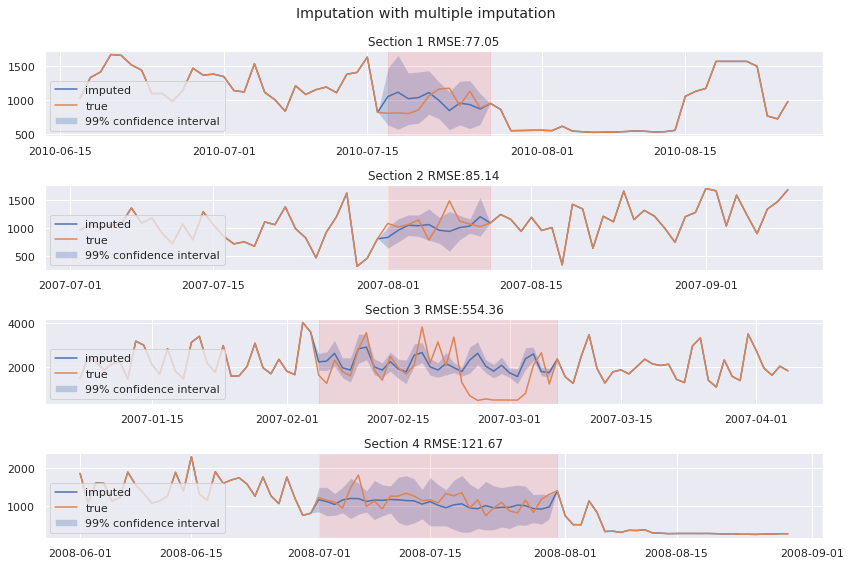

In [16]:
plot_imputaion(title='Imputation with multiple imputation')

### Imputation with Gaussian Process

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,RationalQuadratic

In [24]:
def gaussian_regression(X_train,Y_train, X):    
    noise = 0.25
    kernel = ConstantKernel(1.0) * RBF(length_scale=20.0)
    # kernel = ConstantKernel(10.0) * RationalQuadratic(alpha=1,length_scale=20)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=noise, normalize_y=True)
    gpr.fit(X_train, Y_train)
    mu, std = gpr.predict(X, return_std=True)        
    return mu, std

g_train = train[['y']].copy()
g_train['x'] = np.arange(0,len(train))
g_train = g_train.dropna()
g_train.shape

train['y_mean'], train['y_std']  = gaussian_regression(g_train['x'].values.reshape(-1, 1),
                              g_train['y'],  np.arange(0,len(train)).reshape(-1, 1))  

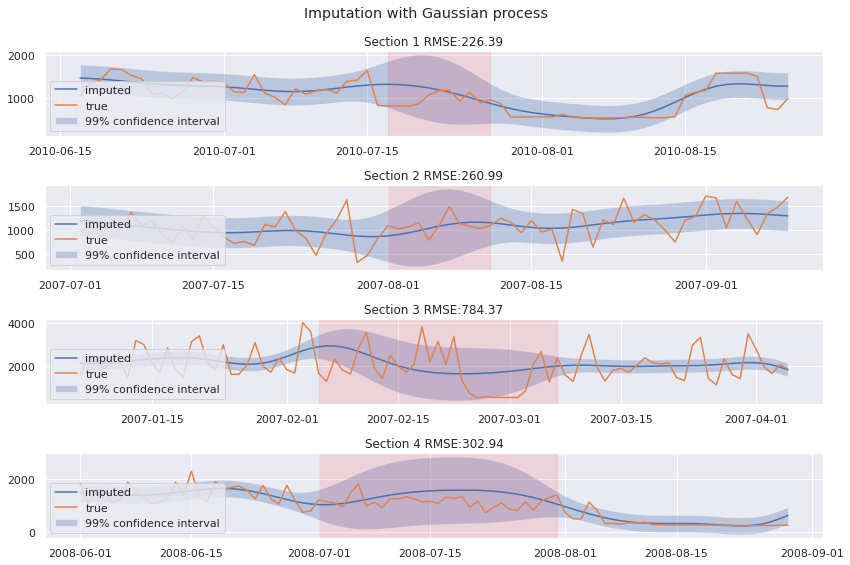

In [25]:
plot_imputaion(title='Imputation with Gaussian process')

### Imputation with forecasting

In [21]:
from statsmodels.tsa.forecasting.theta import ThetaModel

In [22]:
start = 0
train['y_mean'] = train['y'].copy()
train['y_std'] = 0

for section in sorted(ts_missing):
    val = train['y'].values[start:section[0]]
    tm = ThetaModel(endog=val, period=7)
    res = tm.fit()
    pred = res.forecast(section[1]-section[0])
    #save prediction to y_mean
    train.iloc[section[0]:section[1],2] = pred
    start = section[1]
    
assert train['y_mean'].isna().sum()==0

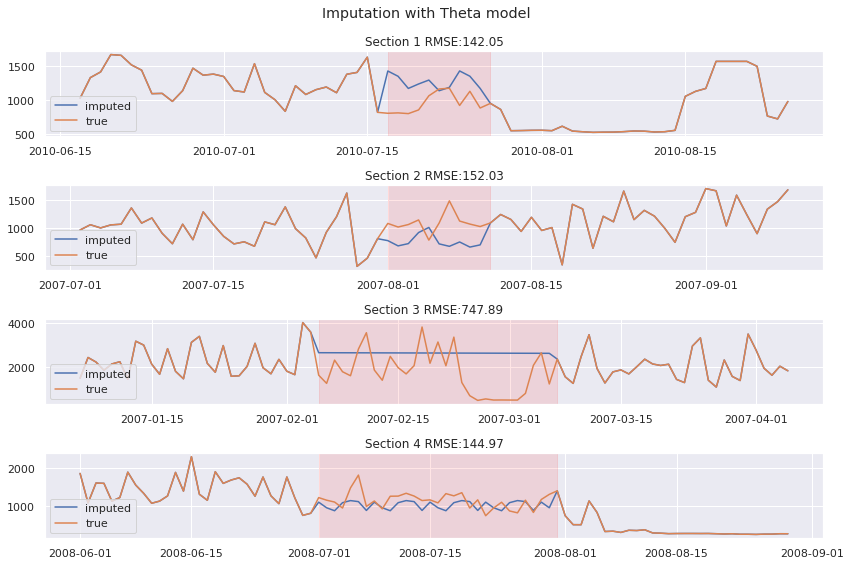

In [23]:
plot_imputaion(show_ci=False, title='Imputation with Theta model')